In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import timedelta
from tqdm import tqdm

### 데이터 불러오기

In [2]:
data = pd.read_csv("Record File__0mA(29s)~30mA(1s)(통합).csv") #통합 데이터
data.describe()

,Voltage(V),Current(A),Resistance(Ohm),Power(W)
count,4.988486e+06,4.988486e+06,4.988486e+06,4.988486e+06
mean,3.889299e+00,9.340380e-04,1.300571e+04,3.475257e-03
std,3.141821e-02,5.146647e-03,5.870463e+04,1.871865e-02
min,1.680000e-02,-1.500000e-03,0.000000e+00,0.000000e+00
25%,3.888700e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.894900e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.899500e+00,0.000000e+00,1.219480e+02,0.000000e+00
max,3.907000e+00,1.399000e+00,6.489843e+05,1.340000e-01


### 데이터 자르기 (time, volt, current)

In [3]:
data = data.iloc[:, :3] #.values

### 시간을 timedelt로 변경하기 위함

In [4]:
date_=[] #replace korean to english

for i in data['Time'].values:
    i = i.replace("오전", "AM")
    i = i.replace("오후", "PM")
    date_.append(i)

In [5]:
date__=[] #split blank

for i in date_:
    date__.append(i.split(" "))

In [6]:
date___=[] #switch index

for i in date__:
    tmp = i[1]
    i[1] = i[2]
    i[2] = tmp
    date___.append(i)

In [7]:
parsing_date=[]

for i in tqdm(date___):
    #print('parsing: ', i, "=", (" ").join(i))
    dt = parse((" ").join(i)) #list to string
    #print(dt)
    #print()
    parsing_date.append(dt)

100%|█████████████████████████████████████████████████████████████████████| 4988486/4988486 [07:02<00:00, 11820.07it/s]


### 기준 전압 인덱스 구하기

In [9]:
comm_A = np.where(data['Current(A)'] > 0.020) #통신 전류

In [10]:
comm_V_ = np.where(data['Voltage(V)'] < 2.000) #2v가 넘는 곳의 인덱스

In [11]:
comm_V = np.array(comm_V_).reshape(len(comm_V_[0]))

#### 전압이 2v이상인 통신 전류 데이터 인덱스

In [12]:
comm_ = comm_A

for i in comm_V:
    comm_ = np.delete(comm_, np.where(comm_ == i))

#### 전압이 2v이하이면서 통신 전류가 흐르는 데이터가 없는 경우

In [10]:
comm_ = np.array(comm_A[0])

In [11]:
comm_

array([      3,       4,       5, ..., 4988382, 4988383, 4988384],
      dtype=int64)

#### 통신 전류 시작 인덱스 하나만

In [12]:
comm = np.array([comm_[0]])

for idx in range(int(len(comm_)-1)):
    if comm_[idx]+1 != comm_[idx+1]:
        comm = np.append(comm, np.array(comm_[idx+1]))

In [13]:
comm

array([      3,     132,     268, ..., 4988164, 4988274, 4988381],
      dtype=int64)

#### 기준 전압은 통신 시작 전류 인덱스 바로 전

In [14]:
criterion = comm - 1

### 전압 회복 시간, 회복률, 전압을 확인하기 위함
- recovery_time [[통신 전, crit_time]]
- recovery_rate [[통신 중(최대), crit_rate]]
- recovery_volt [[통신 전, 통신 중(최소), crit_volt]]
- crit = 기준 전압 회복률
- 회복률이 crit 이하가 되거나 0이 아니면 다음 통신 데이터로
    - 기준 전압과 통신 전압이 같은 부분이 있어 이상한 데이터가 그려짐 (회복률이 0이 아니면)
- np.delete()하는 이유는 처음에 np.zeros(())로 만들었기 때문에 제일 처음에 0 값이 들어가 있음
    - np.empty(())를 사용하면 쓰레기 값이 들어가 있음 (어차피 같음)

In [15]:
recovery_time=np.zeros((1,2)) #시간은 통신 전, 회복(crit) 시간
recovery_rate=np.zeros((1,2)) #통신(최대), crit(0.5 or smaller)
recovery_volt=np.zeros((1,3)) #통신전, 통신(최소), 회복

crit = 0.50

for _, i in enumerate(tqdm(criterion)): #기준 전압
    r = np.array([])
    v = np.array([])
    
    for j in range(int(len(data['Voltage(V)']))):
#         print("crit", i, "current", i+j+1)
#         print("crit", data['Voltage(V)'][i], "current", data['Voltage(V)'][j+i+2])
        
        rate = (data['Voltage(V)'][i] - data['Voltage(V)'][i+j+1]) * 100 #(기준전압 - 현재전압)*100
        r = np.append(r, np.array([rate]))
        v = np.append(v, np.array([data['Voltage(V)'][i+j+1]]))
        
#         print("rate", rate)
#         print("recovery_rate", recovery_rate)
        
        if (rate <= crit) and (rate != 0.0): #회복 전압
            recovery_rate = np.append(recovery_rate, np.array([np.max(r), rate]).reshape(1,2), axis=0)
            
            recovery_time = np.append(recovery_time, np.array([parsing_date[i], parsing_date[i+j]]).reshape(1,2), axis=0)
            
            recovery_volt = np.append(recovery_volt, np.array([data['Voltage(V)'][i], np.min(v), data['Voltage(V)'][i+j+1]]).reshape(1,3), axis=0)
            break
            
recovery_rate = np.delete(recovery_rate, 0, 0)
recovery_time = np.delete(recovery_time, 0, 0)
recovery_volt = np.delete(recovery_volt, 0, 0)

100%|███████████████████████████████████████████████████████████████████████████| 59559/59559 [02:08<00:00, 463.02it/s]


### 그래프를 그려 변화 확인

#### 통신시에 전압을 얼마나 사용하는지 볼 수 있음

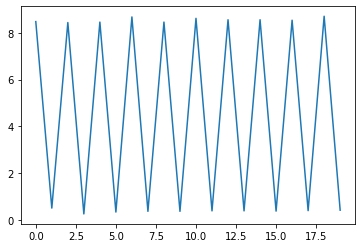

In [16]:
plt.plot(recovery_rate[:10].flatten())

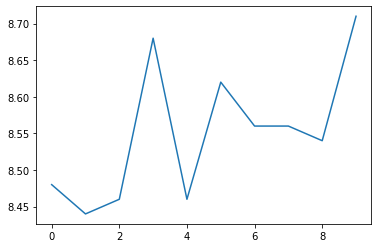

In [17]:
plt.plot(np.max(recovery_rate[:10], axis=1))

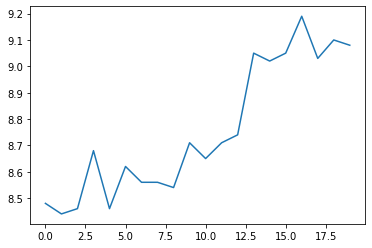

In [18]:
plt.plot(np.max(recovery_rate[:20], axis=1))

In [45]:
(3.9000 - 3.8044) *100

9.560000000000013

In [29]:
np.max(recovery_rate[34:50], axis=1)

array([9.43, 9.4 , 9.43, 6.14, 9.32, 9.48, 9.44, 9.38, 9.39, 9.35, 9.38,
       9.32, 9.75, 9.81, 9.8 , 9.69])

In [30]:
recovery_time[37]

array([datetime.datetime(2021, 9, 24, 16, 47, 15),
       datetime.datetime(2021, 9, 24, 16, 47, 16)], dtype=object)

In [31]:
recovery_volt[37]

array([3.8658, 3.8044, 3.8932])

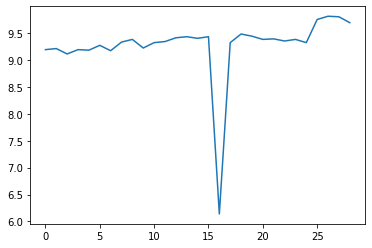

In [25]:
plt.plot(np.max(recovery_rate[21:50], axis=1))

#### 시간은 timedelt형으로 되어 있기 때문에 회복 시간을 보기 위해서는 처리가 필요

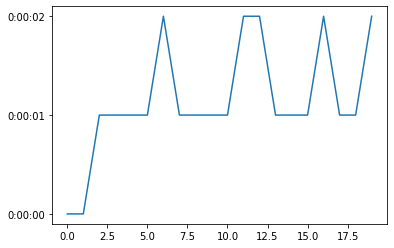

In [32]:
re_time = []

for i in recovery_time:
    re_time.append(str(i[1] - i[0]))
    
plt.plot(re_time[:20])

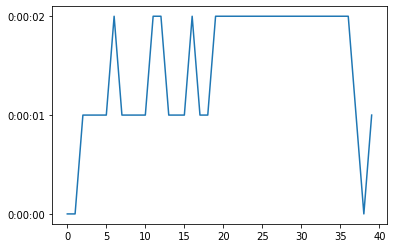

In [41]:
plt.plot(re_time[:40])

#### 통신 전, 통신 중, 회복 전압 그래프

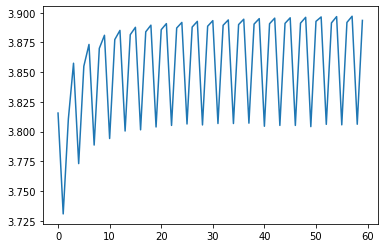

In [33]:
plt.plot(recovery_volt[:20].flatten())

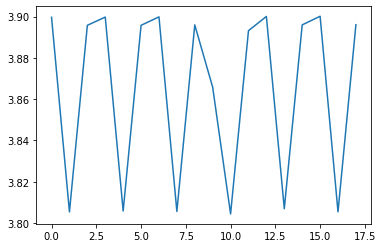

In [39]:
plt.plot(recovery_volt[34:40].flatten())